In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#call library

import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import json
import ta

In [4]:
base_path = '/content/drive/MyDrive/research/valueclassifier/'

In [5]:
import os
import pandas as pd
import numpy as np

'''
이런식으로 사용하면 됩니다.
from preprocesslib import preprocessEach, makeY
X = preprocessEach('overlap')
X bootstrap해서 -> X_final만든 후에
y = makeY('overlap', len(X_final))
'''

def preprocessEach(folder_name):
   # set file path
    folder_path = base_path + f'data/{folder_name}_clean'

    # load file name in folder
    file_names = os.listdir(folder_path)
    data_array = []

    for file in file_names:
        # set file path
        file_path = os.path.join(folder_path, file)
        
        # load csv file as dataframe
        df = pd.read_csv(file_path)

        #preprocessing column
        df['open-close'] = df['Open'] - df['Close'] #추가
        df['open-close'] = df['open-close'] + abs(min(df['open-close'])) #추가
        df['MA5'] = df['Close'].rolling(5).mean() #추가
        df['Diff'] = df['High'] - df['Low']
        df['RSI'] = ta.momentum.rsi(df['Close'])
        temp = ta.trend.macd(df['Close'])
        df['MACD'] = temp + abs(min(temp))

        df = df[['Close','Volume','Diff','open-close','MA5', 'Search','MACD','RSI']]
        # df = df[['Close','Volume','Diff','open-close', 'Search']]
        df.fillna(0, inplace=True)

        #log transform
        df = np.log1p(df)

        #insert list to array
        data_array.append(df)

    return np.array(data_array)

def makeYGrowth(folder_name, filelength):
    if folder_name=='value':
        YGrowth = np.zeros(filelength)
    elif folder_name=='growth':
        YGrowth = np.ones(filelength)

    y = np.column_stack([YGrowth.T])
    return y

def bootstrap(large, small):
    diff = len(large) - len(small)
    bootstrapped = small[np.random.choice(len(small), size=diff, replace=True)]
    return np.concatenate((small, bootstrapped), axis=0)

In [6]:
xGrowths = preprocessEach('growth')
xValues = preprocessEach('value')
xOverlaps = preprocessEach('overlap')

<ipython-input-5-ffa02a1154a1>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)


In [7]:
xGrowths = np.concatenate((xGrowths, xOverlaps), axis=0)

In [8]:
xValues = bootstrap(xGrowths, xValues)

In [9]:
#make y values
yGrowths = makeYGrowth('growth', len(xGrowths))
yValues = makeYGrowth('value', len(xValues))

In [10]:
x = np.concatenate((xGrowths, xValues), axis=0)
y = np.concatenate((yGrowths, yValues), axis=0)

In [11]:
#minmax scaling by element
scaler = MinMaxScaler()
for i in range(8):
    x[:,:,i] = scaler.fit_transform(x[:,:,i])

In [12]:
def splitData(x, y, train_ratio=0.8):
    # shuffle data
    np.random.seed(2023)
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    # split data
    n_train_samples = int(train_ratio * len(x))
    x_train, x_test = x[:n_train_samples], x[n_train_samples:]
    y_train, y_test = y[:n_train_samples], y[n_train_samples:]

    return x_train, x_test, y_train, y_test

In [13]:
X_train, X_test, Y_train, Y_test = splitData(x,y,0.8)

In [14]:
X_train = np.nan_to_num(X_train, nan=0)
X_test = np.nan_to_num(X_test, nan=0)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [15]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300)
mc = ModelCheckpoint('best_model_value.h5', monitor='val_acc', mode='max', save_best_only=True)

def create_model():
    model = Sequential()
    model.add(GRU(64, input_shape=(1248,8), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(32))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [ ]:
#split data for cross validation
def splitDataCrossVal(x, y, fold=3):
    # shuffle data
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    x_split = []
    y_split = []
    # split data
    n_samples = int(len(x)/fold)
    for i in range(fold-1):
      x_split.append(x[i*n_samples:(i+1)*n_samples])
      y_split.append(y[i*n_samples:(i+1)*n_samples])
    x_split.append(x[(fold-1)*n_samples:])
    y_split.append(y[(fold-1)*n_samples:])

    return x_split, y_split

In [ ]:
def cvsplitData(x,y, ind):
  x_test = x[ind]
  y_test = y[ind]
  cnt = 0
  for i in range(len(x)):
    if i!=ind:
      if cnt == 0:
        x_train = x[i]
        y_train = y[i]
        cnt += 1
      else:
        x_train = np.concatenate((x_train, x[i]))
        y_train = np.concatenate((y_train, y[i]))
  return x_train, x_test, y_train, y_test

In [ ]:
x_split, y_split = splitDataCrossVal(X_train, Y_train)

In [ ]:
print(len(x_split))
accuracy_cross_val = []
for i in range(len(x_split)):
  x_train, x_test, y_train, y_test = cvsplitData(x_split, y_split, i)
  x_train = np.nan_to_num(x_train, nan=0)
  x_test = np.nan_to_num(x_test, nan=0)

  model = create_model()

  history=model.fit(x_train, y_train, epochs=2000, validation_data=(x_test, y_test), callbacks=[es, mc])
  model=load_model('best_model_value.h5')
  loss, accuracy = model.evaluate(x_test, y_test)
  accuracy_cross_val.append(accuracy)
  with open(f'history_value{i}.json', 'w') as f:
      json.dump(history.history, f)
print("cross validation accuracy:{}".format(accuracy_cross_val))
print("average cross validation accuracy:{}".format(sum(accuracy_cross_val)/len(accuracy_cross_val)))

3
Epoch 1/2000
59/59 [==============================] - 10s 102ms/step - loss: 0.6903 - acc: 0.5294 - val_loss: 0.6846 - val_acc: 0.5621
Epoch 2/2000
59/59 [==============================] - 4s 71ms/step - loss: 0.6826 - acc: 0.5711 - val_loss: 0.6718 - val_acc: 0.5696
Epoch 3/2000
59/59 [==============================] - 4s 74ms/step - loss: 0.6808 - acc: 0.5684 - val_loss: 0.6680 - val_acc: 0.5835
Epoch 4/2000
59/59 [==============================] - 5s 87ms/step - loss: 0.6818 - acc: 0.5695 - val_loss: 0.6696 - val_acc: 0.5653
Epoch 5/2000
59/59 [==============================] - 5s 80ms/step - loss: 0.6779 - acc: 0.5759 - val_loss: 0.6697 - val_acc: 0.5835
Epoch 6/2000
59/59 [==============================] - 4s 76ms/step - loss: 0.6758 - acc: 0.5888 - val_loss: 0.6620 - val_acc: 0.6135
Epoch 7/2000
59/59 [==============================] - 5s 83ms/step - loss: 0.6739 - acc: 0.5850 - val_loss: 0.6559 - val_acc: 0.6103
Epoch 8/2000
59/59 [==============================] - 4s 75ms/ste

In [ ]:
count_01 = np.sum((y_test == [0,1]).all(axis=1))
count_10 = np.sum((y_test == [1,0]).all(axis=1))

print(f"[01]의 개수: {count_01}")
print(f"[10]의 개수: {count_10}")

[01]의 개수: 478
[10]의 개수: 458


In [ ]:
best_model=load_model('best_model_value.h5')
loss, accuracy = best_model.evaluate(x_test, y_test)
y_pred_prob = best_model.predict(x_test)

30/30 [==============================] - 2s 34ms/step


In [ ]:
hiostory_dict_list = []
for i in range(len(x_split)):
    with open(f'history_value{i}.json', 'r') as f:
        hiostory_dict_list.append(json.load(f))

In [16]:
def model_loss(history):
    epochs = range(1, len(history['val_acc']) + 1)
    plt.plot(epochs, history['loss'])
    plt.plot(epochs, history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [17]:
def model_acc(history):
    epochs = range(1, len(history['val_acc']) + 1)
    plt.plot(epochs, history['acc'])
    plt.plot(epochs, history['val_acc'])
    plt.title('model acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [27]:
for i in hiostory_dict_list:
    model_loss(i)
    model_acc(i)

NameError: ignored

In [18]:
mc_final = ModelCheckpoint('best_growth_value_final.h5', monitor='val_acc', mode='max', save_best_only=True)

In [19]:
final_model = create_model()

In [20]:
history_final=final_model.fit(X_train, Y_train, epochs=2000, batch_size = 64, validation_split=0.2, callbacks=[es, mc_final])
with open('history_growth_final.json', 'w') as f:
      json.dump(history_final.history, f)

Epoch 1/2000
24/24 [==============================] - 8s 110ms/step - loss: 0.6866 - acc: 0.5343 - val_loss: 0.6841 - val_acc: 0.5526
Epoch 2/2000
24/24 [==============================] - 2s 92ms/step - loss: 0.6737 - acc: 0.5897 - val_loss: 0.6721 - val_acc: 0.5789
Epoch 3/2000
24/24 [==============================] - 2s 98ms/step - loss: 0.6613 - acc: 0.6049 - val_loss: 0.6665 - val_acc: 0.5921
Epoch 4/2000
24/24 [==============================] - 2s 72ms/step - loss: 0.6572 - acc: 0.6174 - val_loss: 0.6639 - val_acc: 0.5947
Epoch 5/2000
24/24 [==============================] - 2s 78ms/step - loss: 0.6567 - acc: 0.6154 - val_loss: 0.6607 - val_acc: 0.5737
Epoch 6/2000
24/24 [==============================] - 2s 76ms/step - loss: 0.6547 - acc: 0.6009 - val_loss: 0.6625 - val_acc: 0.5842
Epoch 7/2000
24/24 [==============================] - 2s 71ms/step - loss: 0.6482 - acc: 0.6135 - val_loss: 0.6557 - val_acc: 0.6053
Epoch 8/2000
24/24 [==============================] - 2s 71ms/step -

In [21]:
best_model_final=load_model('best_model_value_final.h5')
loss_f, accuracy_f = best_model_final.evaluate(X_test, Y_test)
y_pred_prob_f = best_model_final.predict(X_test)

15/15 [==============================] - 1s 24ms/step


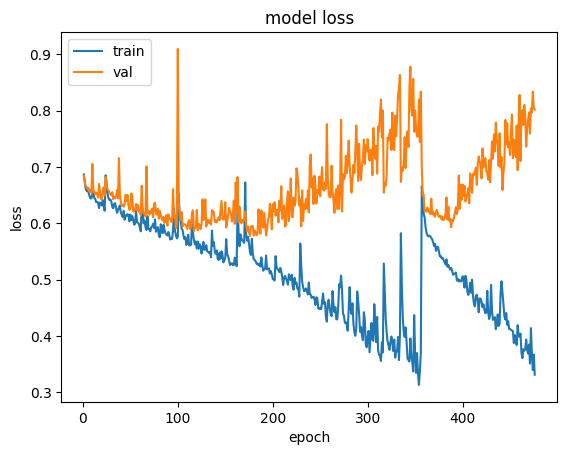

In [22]:
with open('history_growth_final.json', 'r') as f:
  model_loss(json.load(f))

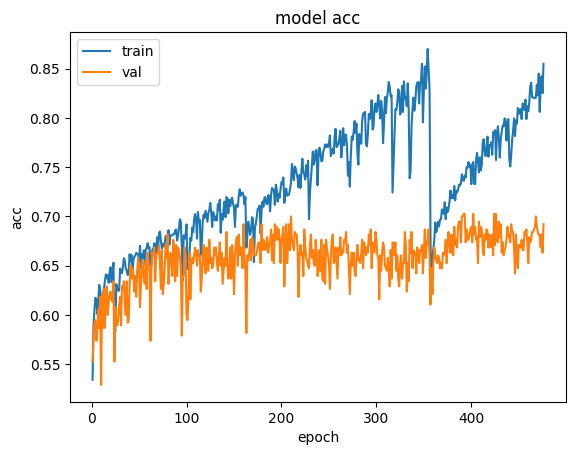

In [23]:
with open('history_growth_final.json', 'r') as f:
  model_acc(json.load(f))